# Load Data

In [239]:
import pandas as pd

predicted_data_puskesmas = pd.read_csv("predicted-review.csv")

predicted_data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,is_positive
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id,1
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id,0
2,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id,1
3,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id,0
4,Yunia Ardina,1,Saya mau kasih masukan sekaligus protes..\n\nS...,Puskesmas Simomulyo,kasih masuk protes tanggal february jaman prik...,id,0


In [240]:
detail_puskesmas = pd.read_csv("scrapping/cleaned_puskesmas.csv")

detail_puskesmas.head()

,name,kepala puskesmas,alamat,telepon,url,rate,review_num
0,Puskesmas Asemrowo,dr. Diah Miryati,Jln. Asem Raya No. 8,(031) 5456122 / 081252965070,https://www.google.com/maps/place/Puskesmas+As...,"3,5",(131)
1,Puskesmas Balas Klumprik,"dr. Yessy Pebriaty Sukatendel, MM",Jln. Raya Balas Klumprik,(031) 7665219,https://www.google.com/maps/place/Puskesmas+Ba...,"4,1",(96)
2,Puskesmas Balongsari,dr. Dewi Ayuning Asih,Jln. Balongsari Tama No. 2 Surabaya,(031) 7417104,https://www.google.com/maps/place/Puskesmas+Ba...,"3,9",(308)
3,Puskesmas Bangkingan,dr. Tri Indah Rachmawati,Jln. Banyu Urip Kidul 6/8,(031) 5685424 - 5615292 / 081334932007,https://www.google.com/maps/place/Puskesmas+Ba...,"3,8",(84)
4,Puskesmas Banyu Urip,"dr. Winartuti Santoso, M.Kes",Jln. Banyu Urip Kidul 6/8,(031) 7405936,https://www.google.com/maps/place/Puskesmas+Ba...,"3,2",(170)


# Get longtiude and latitude of each puskesmas

In [241]:
import plotly.express as px
from tqdm.notebook import tqdm
import requests
import random


def get_lat_lon(puskesmas_name):
    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0",
        "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.110 Mobile Safari/537.36",
        "Mozilla/5.0 (iPad; CPU OS 13_7 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.2 Mobile/15E148 Safari/604.1",
    ]
    attempts = 0
    while attempts < 10:
        try:
            headers = {"User-Agent": random.choice(user_agents)}
            url = f"https://nominatim.openstreetmap.org/search?q={puskesmas_name}, surabaya&format=jsonv2"
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                return data[0]["lat"], data[0]["lon"], data[0]["display_name"]
            else:
                attempts += 1
                # print(f"Attempt {attempts}: Failed to get data for {puskesmas_name}")
        except Exception as e:
            attempts += 1
            # print(f"Attempt {attempts}: Error for {puskesmas_name} - {e}")
    return None, None


tqdm.pandas()
detail_puskesmas["lat"], detail_puskesmas["lon"], detail_puskesmas["display_name"] = (
    zip(*detail_puskesmas["name"].progress_apply(get_lat_lon))
)

print(detail_puskesmas.columns)

detail_puskesmas = detail_puskesmas.rename(columns={"name": "puskesmas_name"})

positive_review_counts = predicted_data_puskesmas.groupby("puskesmas_name")[
    "is_positive"
].sum()
total_review_counts = predicted_data_puskesmas.groupby("puskesmas_name")[
    "is_positive"
].count()
percentage_positive_reviews = (
    positive_review_counts / total_review_counts * 100
).reset_index()
percentage_positive_reviews.columns = ["puskesmas_name", "positive_percentage"]

detail_puskesmas = detail_puskesmas.merge(
    percentage_positive_reviews, on="puskesmas_name", how="left"
)

  0%|          | 0/63 [00:00<?, ?it/s]

Index(['name', 'kepala puskesmas', 'alamat', 'telepon', 'url', 'rate',
       'review_num', 'lat', 'lon', 'display_name'],
      dtype='object')


# Geolocation of each puskesmas reviewed from google maps

In [242]:
data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

fig = px.scatter_mapbox(
    data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": data_for_plotting["lat"].mean(),
        "lon": data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron",
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Puskesmas Positive Review Percentage",
)

fig.update_traces(marker=dict(size=64, opacity=0.7), selector=dict(mode="markers+text"))

fig.update_layout(
    legend_title_text="Positive Review %",
    title=dict(text="Puskesmas Positive Review Percentage", x=0.5, xanchor="center"),
)

fig.update_layout(width=800, height=800)
fig.show()

/tmp/ipykernel_12421/295796426.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/295796426.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/295796426.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Top 10 Puskesmas with the positive review

In [243]:
import pandas as pd
import plotly.express as px

data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

top_10_data_for_plotting = data_for_plotting.sort_values(
    by="positive_percentage", ascending=False
).head(10)

fig = px.scatter_mapbox(
    top_10_data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": top_10_data_for_plotting["lat"].mean(),
        "lon": top_10_data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron", 
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Top 10 Puskesmas with Positive Review Percentage",
    range_color=[detail_puskesmas['positive_percentage'].min(), detail_puskesmas["positive_percentage"].max()],
)

fig.update_traces(marker=dict(size=28, opacity=0.7), textposition="top center")

fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Positivity Rate: %{marker.color:.2f}%"
)

fig.update_coloraxes(colorbar_title="Positivity Rate (%)")

fig.update_layout(
    legend=dict(
        title_font=dict(size=14, color="blue"),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=2,
    ),
    title=dict(
        text="Top 10 Puskesmas with Positive Review Percentage", x=0.5, xanchor="center"
    ),
    width=800,
    height=800,
)

fig.show()

/tmp/ipykernel_12421/2427489040.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/2427489040.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/2427489040.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Top 10 Puskesmas with the negative review

In [244]:
import pandas as pd
import plotly.express as px

data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

top_10_data_for_plotting = data_for_plotting.sort_values(
    by="positive_percentage", ascending=True
).head(10)

fig = px.scatter_mapbox(
    top_10_data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": top_10_data_for_plotting["lat"].mean(),
        "lon": top_10_data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron",
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Top 10 Puskesmas with Negative Review Percentage",
    range_color=[detail_puskesmas['positive_percentage'].min(), detail_puskesmas["positive_percentage"].max()],
)

fig.update_traces(marker=dict(size=28, opacity=0.7), textposition="top center")

fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Positivity Rate: %{marker.color:.2f}%",
)

fig.update_coloraxes(colorbar_title="Positivity Rate (%)")

fig.update_layout(
    legend=dict(
        title_font=dict(size=14, color="blue"),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=2,
    ),
    title=dict(
        text="Top 10 Puskesmas with Negative Review Percentage", x=0.5, xanchor="center"
    ),
    width=800,
    height=800,
)

fig.show()

/tmp/ipykernel_12421/118797639.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/118797639.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/118797639.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Why positive? Why negative?

## Positive

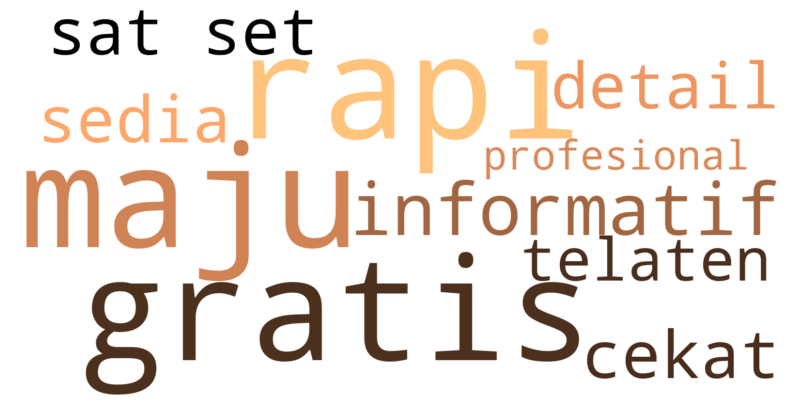

In [245]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_reviews = predicted_data_puskesmas["cleaned_review_text"]

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_matrix = vectorizer.fit_transform(all_reviews)

word_scores = np.sum(tfidf_matrix, axis=0)

features = vectorizer.get_feature_names_out()
scores = word_scores.A1
word_score_dict = dict(zip(features, scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

positive_reviews = ' '.join(predicted_data_puskesmas[predicted_data_puskesmas['is_positive'] == 1]['cleaned_review_text'])

N = 100
common_words = set([word for word, score in sorted_words[:N]])

filtered_positive_reviews = ' '.join([word for word in positive_reviews.split() if word not in common_words])
filtered_positive_reviews = ' '.join([word for word in filtered_positive_reviews.split() if word not in detail_puskesmas['puskesmas_name'].str.lower().str.split().str[1].values])

stop_words = ["bu", "sih", "oke", "ya", "aja", "udah", "ok", "suka", "pas", "sukses", "semangat", "wetan", "bovid", "tes", "jalan", "darah", "lahir", "imunisasi", "booster", "bintang", "booster", "nakednya", "warga", "alam", "pokok", "medis", "kartu", "tanda", "arah", "proses", "farmasi", "usia", "ramai"]

filtered_positive_reviews = ' '.join([word for word in filtered_positive_reviews.split() if word not in stop_words])


wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",
    max_words=10, 
    colormap="copper",
    prefer_horizontal=1.0,
    min_font_size=10,
    max_font_size=300,
    contour_width=3,
    contour_color='steelblue'
).generate(filtered_positive_reviews)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [246]:
top_10_words = pd.Series(filtered_positive_reviews.split()).value_counts().head(10).index

for word in top_10_words:
    print(f"Word: {word}")
    sample_reviews = predicted_data_puskesmas[predicted_data_puskesmas['cleaned_review_text'].str.contains(word) & (predicted_data_puskesmas['is_positive'] == 1) & (predicted_data_puskesmas['cleaned_review_text'].str.len() > 50)]
    for idx, review in sample_reviews.sample(5)['review_text'].items():
        print(f'{idx}: {review}')
    
    print()

Word: rapi
231: Pelayanan sudah Oke, antrian tersistem dan rapi. Pelayanan bagus mulai dr front office hingga apoteker nya. Ruang tunggu sudah bagus, ber AC dan berkipas angin ria. Dokter ramah dan cepat tanggap. Enak pakai pendaftaran online
2725: Saya membaca review sebelumnya sepertinya sudah tidak valid, menurut saya
Tempatnya rapi dan bersih,
Pelayanannya cepat dan tanggap, ramah sekali, mulai dari bapak parkir, loket, sampai semua orang didalam poli. Semuanya ramah dan baik

Untuk pengambilan nomor antrian saya sarankan ambil secara online lalu di tunjukkan di reseptioni untuk print no antrian, datang tepat waktu pada jam yg tertulis di antriannya

Didalam puskesmas ada tanaman hijau yang menyegarkan pandangan, suasanya juga tenang..
6075: Meskipun tempatnya agak terpencil tapi tidak mengurangi keramaian pasiennya , datang jam 7 Uda lumayan yang datang, saran aja lebih baik daftar online sebelum hari H, layanan lumayan lengkap, ada lab nya juga di lantai 2, lumayan rapi dan terti

## Negative

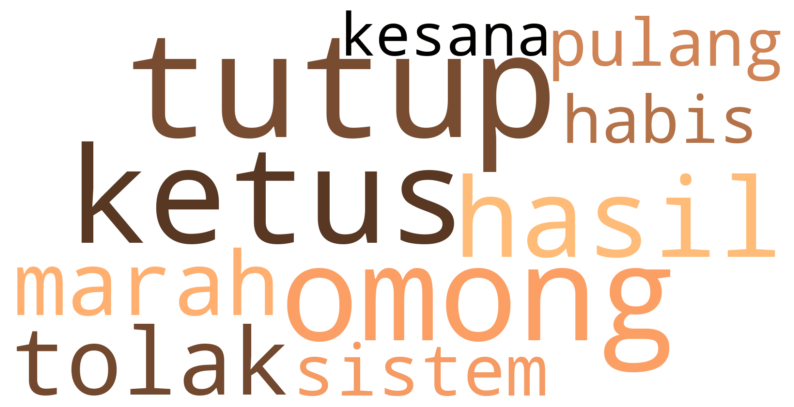

In [247]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_reviews = predicted_data_puskesmas["cleaned_review_text"]

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_matrix = vectorizer.fit_transform(all_reviews)

word_scores = np.sum(tfidf_matrix, axis=0)

features = vectorizer.get_feature_names_out()
scores = word_scores.A1
word_score_dict = dict(zip(features, scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

negative_reviews = ' '.join(predicted_data_puskesmas[predicted_data_puskesmas['is_positive'] == 0]['cleaned_review_text'])

N = 100
common_words = set([word for word, score in sorted_words[:N]])

filtered_negative_reviews = ' '.join([word for word in negative_reviews.split() if word not in common_words])
filtered_negative_reviews = ' '.join([word for word in filtered_negative_reviews.split() if word not in detail_puskesmas['puskesmas_name'].str.lower().str.split().str[1].values])

stop_words = ["bu", "sih", "maaf", "oke", "ya", "aja", "udah", "ok", "suka", "pas", "sukses", "nyata", "ala", "tua", "jelek", "lihat", "nama", "eh", "parah", "alas", "keluh", "laku", "salah"]

filtered_negative_reviews = ' '.join([word for word in filtered_negative_reviews.split() if word not in stop_words])

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",
    max_words=10, 
    colormap="copper",
    prefer_horizontal=1.0,
    min_font_size=10,
    max_font_size=300,
    contour_width=3,
    contour_color='steelblue'
).generate(filtered_negative_reviews)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [248]:
top_10_words = pd.Series(filtered_negative_reviews.split()).value_counts().head(10).index

for word in top_10_words:
    print(f"Word: {word}")
    sample_reviews = predicted_data_puskesmas[predicted_data_puskesmas['cleaned_review_text'].str.contains(word) & (predicted_data_puskesmas['is_positive'] == 0) & (predicted_data_puskesmas['cleaned_review_text'].str.len() > 50)]
    for idx, review in sample_reviews.sample(5)['review_text'].items():
        print(f'{idx}: {review}')
    
    print()

Word: tutup
1256: saya antrian online no 36 tertera jam 10.29-10.44 datang sebelum pukul yang tetera dari depan pintu sudah diinfo tutup tidak ada dokter dengan info pandemi covid maximal jam 09.00, suruh kembali lagi besok/cari klinik lain saja, sudah 2x kejadian dipuskesmas putat seperti ini awal antar bapak saya sakit juga seperti itu selalu tutup sebelum jam berlaku, Kalau memang tutup operasional gerbang depan tutup saja tidak usah dibuka, pendaftaran secara online dibuat otomatis jika sudah tidak melayani pasien, selalu hadir sesuai jam sampai tempat diinfo tutup.
7148: Pelayanan sangat lelet dan lambat, masa iyaa minta surat rujukan untuk bpjs aja dari pendaftaran jam 07.30 sampe jam 10.00 belom beres … mana dokter dan petugasnya sangat ga ramah sama pasien, tutup aja lah ni puskesmas !!!
134: Tolong infonya di perbaiki. Saya sakit keras nyari puskesmas yang buka di hari minggu, di google di tampilkan di sini. Siang2 naik sepeda motor ke sini. Sampek tempatnya ternyata tutup sep

# Top 10 Detailed Review for Positive and Negative Puskesmas

## Positive

In [249]:
most_positive_review = detail_puskesmas.sort_values(
    "positive_percentage", ascending=False
).head(10)
most_positive_review

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
50,Puskesmas Sidotopo Wetan,dr. Evi Susanti,Jln. Randu 38,(031) 3767737,https://www.google.com/maps/place/Puskesmas+Si...,"4,4",(537),-7.22658925,112.76350132938722,"Puskesmas Sidotopo Wetan, Jalan Randu, RW 10, ...",82.278481
24,Puskesmas Ketabang,dr. Joyce Hestia Nugrahanti,Jln. Jaksa Agung Suprapto No 10,(031) 5311999,https://www.google.com/maps/place/Puskesmas+Ke...,"4,5",(377),-7.2580613,112.74677403040269,"Puskesmas Ketabang, Jalan Jimerto, RW 05, Keta...",78.947368
57,Puskesmas Tanjungsari,dr. Yunita Andriani,Jln. Raya Tanjungsari No.116,(031) 7497858,https://www.google.com/maps/place/Puskesmas+Ta...,"4,2",(300),-7.2594043500000005,112.6892628357994,"Puskesmas Tanjungsari, Jalan Raya Tandes Lor, ...",77.027027
56,Puskesmas Tanah Kali Kedinding,dr. Era Kartikawati,Jln. H. M. Noer 226,(031) 51501347,https://www.google.com/maps/place/Puskesmas+Ta...,"4,2",(572),-7.23037625,112.77446968315311,"Puskesmas Tanah Kali Kedinding, Jalan Kedung C...",76.288660
51,Puskesmas Simolawang,dr. Dwi Sapta Edy Purnama,Jln. Simolawang II Barat 45 A,(031) 3717433 / 085954480937,https://www.google.com/maps/place/Puskesmas+Si...,"4,2",(148),-7.2348687,112.75104985,"Puskesmas Simolawang, Jalan Simolawang Kalimir...",75.862069
42,Puskesmas Pucang Sewu,drg. Ummi Latifah,Jln. Pucang Anom Timur No. 72,(031) 5018527,https://www.google.com/maps/place/Puskesmas+Pu...,"4,4",(464),-7.28659415,112.75552826261239,"Puskesmas Pucang Sewu, Jalan Kalibokor, RW 08,...",75.242718
1,Puskesmas Balas Klumprik,"dr. Yessy Pebriaty Sukatendel, MM",Jln. Raya Balas Klumprik,(031) 7665219,https://www.google.com/maps/place/Puskesmas+Ba...,"4,1",(96),-7.3315249,112.69002720464968,"Puskesmas Balas Klumprik, Jalan Balas Klumprik...",73.684211
8,Puskesmas Dukuh Kupang,dr. Khusnul Khowatin,Jln. Dukuh Kupang 25/48,(031) 5677615,https://www.google.com/maps/place/Puskesmas+Du...,"4,0",(548),-7.2832360000000005,112.71222568060509,"Puskesmas Dukuh Kupang, Jalan Dukuh Kupang Gan...",71.565495
61,Puskesmas Wonokromo,drg. Dwiana Yuniarti,Jln. Karangrejo VI/4,(031) 8281647 / 082143561190,https://www.google.com/maps/place/Puskesmas+Wo...,"4,2",(349),-7.303176499999999,112.7303924779992,"Puskesmas Wonokromo, Jalan Karang Rejo VI, RW ...",71.502591
62,Puskesmas Wonokusumo,dr. Heri Siswanto,Jln. Wonokusumo Tengah No.55,(031) 3717597,https://www.google.com/maps/place/Puskesmas+Wo...,"4,2",(410),-7.219663649999999,112.75256160671904,"Puskesmas Wonokusumo, Jalan Wonokusumo Tengah,...",71.497585


## Negative

In [250]:
most_negative_review = detail_puskesmas.sort_values(
    "positive_percentage", ascending=True
).head(10)
most_negative_review

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
34,Puskesmas Morokrembangan,dr. Nurul Ihsani,Jln. Tambakasri 13/7 Morokrembangan,(031) 7493259,https://www.google.com/maps/place/Puskesmas+Mo...,"1,9",(108),-7.2347805,112.71244346706712,"Puskesmas Moro Krembangab, Jalan Tambak Asri X...",10.666667
49,Puskesmas Sidotopo,dr. Galih Satryo Utomo,"Jl. Pegirian No.239, Sidotopo",(031) 3767735,https://www.google.com/maps/place/Puskesmas+Si...,"2,8",(80),-7.23034775,112.74588161903259,"Puskesmas Sidotopo, Jalan Sidodadi, RW 07, Sim...",27.659574
33,Puskesmas Mojo,"dr. Ratna Megasari, M.Kes",Jln. Mojo Klanggru Wetan 2/11,(031) 5932332,https://www.google.com/maps/place/Puskesmas+Mo...,"2,6",(285),-7.2709021499999995,112.77082440581847,"Puskesmas Mojo Surabaya, Jalan Mojo Klanggru W...",31.606218
22,Puskesmas Kenjeran,dr. Rosna Suswanti,Jl. Tambak Deres 2 Surabaya,089515356046,https://www.google.com/maps/place/Puskesmas+Ke...,"3,2",(165),-7.24111075,112.79527909779556,"Puskesmas Kenjeran, Jalan Abdul Latif, RW 01, ...",38.461538
18,Puskesmas Kalirungkut,dr. Bernadetta Martini,Jln. Rungkut Puskesmas No. 1,(031) 8700668,https://www.google.com/maps/place/Puskesmas+Ka...,"3,4",(289),-7.3222179999999994,112.77076210366917,"Puskesmas Kalirungkut, Jalan Puskesmas, RW 07,...",40.000000
12,Puskesmas Gundih,"dr. Tita Pusparini, M. Kes",Jln. Margodadi 36 - 38 Surabaya,(031) 5476275,https://www.google.com/maps/place/Puskesmas+Gu...,"3,1",(117),-7.24724475,112.72539044999999,"Puskesmas Gundih, Jalan Margodadi, RW 07, Gund...",41.333333
4,Puskesmas Banyu Urip,"dr. Winartuti Santoso, M.Kes",Jln. Banyu Urip Kidul 6/8,(031) 7405936,https://www.google.com/maps/place/Puskesmas+Ba...,"3,2",(170),-7.2715069,112.72002732026792,"Puskesmas Banyu Urip, Jalan Banyu Urip Kidul V...",42.201835
20,Puskesmas Kedungdoro,"dr. Diah Roichan Arifiani, M.Kes",Jln. Kaliasin Pompa 79-81 Surabaya,(031) 5345968,https://www.google.com/maps/place/Puskesmas+Ke...,"3,2",(145),-7.26370155,112.73824149999999,"Puskesmas Kedungdoro, Jalan Kaliasin Gang VI, ...",43.181818
40,Puskesmas Peneleh,dr. Ayu Ekanita Hendrayani,Jln. Makam Peneleh No.35,(031) 5343473,https://www.google.com/maps/place/Puskesmas+Pe...,"3,2",(152),-7.2523042,112.74083083291245,"Puskesmas Peneleh, Jalan Makam Peneleh, Makam ...",43.478261
58,Puskesmas Tembok Dukuh,drg. Tiyas Pranadani,Jln. Kalibutuh No 26 Surabaya,(031) 5343410,https://www.google.com/maps/place/Puskesmas+Te...,"3,7",(266),-7.254527449999999,112.71921325,"Puskesmas Tembok Dukuh, Jalan Kalibutuh, RW 02...",46.153846


# Detect Overall Sentiment about 3 Quality Measures by https://www.ncbi.nlm.nih.gov/books/NBK222274/pdf/Bookshelf_NBK222274.pdf

1. Safety
2. Effectiveness, Efficiency & Timeliness
3. Patient-centeredness & Equity

In [251]:
import pandas as pd

predicted_data_puskesmas = pd.read_csv("predicted-review.csv")

In [252]:
from fuzzywuzzy import fuzz

safety_words = ["aman", "selamat", "nyaman", "terjamin", "lindungi", "perlindungan", "keamanan", "keselamatan", "amanah", "amanat"]

safety_reviews = predicted_data_puskesmas[predicted_data_puskesmas["cleaned_review_text"].apply(lambda x: any(fuzz.partial_ratio(word, x) > 80 for word in safety_words))]
print(safety_reviews.shape)
print(safety_reviews["is_positive"].value_counts(normalize=True))

(802, 7)
is_positive
1    0.750623
0    0.249377
Name: proportion, dtype: float64


In [253]:
from fuzzywuzzy import fuzz

effectiveness_words = ["efektif", "efektivitas", "efisien", "efisiensi", "cepat", "cepatan", "tepat", "tepatan", "waktu", "waktunya", "waktu", "waktunya", "hasil", "hasilnya", "berhasil", "berhasilnya", "sukses", "suksesnya", "beres", "beresnya", "selesai", "selesainya", "selesai", "selesainya", "segera", "segeranya", "segera", "segeranya", "tuntas", "tuntasnya", "tuntas", "tuntasnya", "lengkap", "lengkapnya", "lengkap", "lengkapnya", "memuaskan", "memuaskannya", "memuaskan", "memuaskannya", "puas", "puasnya", "puas", "puasnya", "bagus", "bagusnya", "bagus", "bagusnya", "baik", "baiknya"]
efficiency_words = ["efisien", "efisiensi", "hemat", "hematnya", "hemat", "hematnya", "murah", "murahnya", "murah", "murahnya", "biaya", "biayanya", "biaya", "biayanya", "uang", "uangnya", "uang", "uangnya", "tarif", "tarifnya", "tarif", "tarifnya", "harga", "harganya", "harga", "harganya", "mahal", "mahalnya", "mahal", "mahalnya", "berkualitas", "berkualitasnya", "berkualitas", "berkualitasnya", "ramah", "ramahnya", "ramah", "ramahnya", "cepat", "cepatnya", "cepat", "cepatnya", "tepat", "tepatnya", "tepat", "tepatnya", "waktu", "waktunya", "waktu", "waktunya", "hasil", "hasilnya", "berhasil", "berhasilnya", "sukses", "suksesnya", "beres", "beresnya", "selesai", "selesainya", "selesai", "selesainya", "segera", "segeranya", "segera", "segeranya", "tuntas", "tuntasnya", "tuntas", "tuntasnya", "lengkap", "lengkapnya", "lengkap", "lengkapnya", "memuaskan", "memuaskannya", "memuaskan", "memuaskannya", "puas", "puasnya", "puas", "puasnya", "bagus", "bagusnya", "bagus", "bagusnya", "baik", "baiknya"]
timeliness_words = ["cepat", "cepatan", "tepat", "tepatan", "waktu", "waktunya", "waktu", "waktunya", "hasil", "hasilnya", "berhasil", "berhasilnya", "sukses", "suksesnya", "beres", "beresnya", "selesai", "selesainya", "selesai", "selesainya", "segera", "segeranya", "segera", "segeranya", "tuntas", "tuntasnya", "tuntas", "tuntasnya", "lengkap", "lengkapnya", "lengkap", "lengkapnya", "memuaskan", "memuaskannya", "memuaskan", "memuaskannya", "puas", "puasnya", "puas", "puasnya", "bagus", "bagusnya", "bagus", "bagusnya", "baik", "baiknya"]

overall_words_of_interest = set(effectiveness_words).union(efficiency_words).union(timeliness_words)

effective_efficiency_timeliness_reviews = predicted_data_puskesmas[predicted_data_puskesmas["cleaned_review_text"].apply(lambda x: any(fuzz.partial_ratio(word, x) > 80 for word in overall_words_of_interest))]
print(effective_efficiency_timeliness_reviews.shape)
print(effective_efficiency_timeliness_reviews.is_positive.value_counts(normalize=True))

(5285, 7)
is_positive
1    0.776727
0    0.223273
Name: proportion, dtype: float64


In [254]:
from fuzzywuzzy import fuzz

patient_centeredness_words = ["ramah", "ramahnya", "ramah", "ramahnya", "sopan", "sopannya", "sopan", "sopannya"]
equity_words = ["adil", "adilnya", "adil", "adilnya", "layak", "layaknya", "layak", "layaknya", "pantas", "pantasnya", "pantas", "pantasnya", "seimbang", "seimbangnya", "seimbang", "seimbangnya", "setara", "setaranya", "setara", "setaranya", "sama", "samanya", "sama", "samanya", "merata", "meratanya", "merata", "meratanya", "seadil", "seadilnya", "seadil", "seadilnya", "seimbang", "seimbangnya", "seimbang", "seimbangnya", "setara", "setaranya", "setara", "setaranya", "sama", "samanya", "sama", "samanya", "merata", "meratanya", "merata", "meratanya", "seadil", "seadilnya", "seadil", "seadilnya", "seimbang", "seimbangnya", "seimbang", "seimbangnya", "setara", "setaranya", "setara", "setaranya", "sama", "samanya", "sama", "samanya", "merata", "meratanya", "merata", "meratanya", "seadil", "seadilnya", "seadil", "seadilnya", "seimbang", "seimbangnya", "seimbang", "seimbangnya", "setara", "setaranya", "setara", "setaranya", "sama", "samanya", "sama", "samanya", "merata", "meratanya", "merata", "meratanya", "seadil", "seadilnya", "seadil", "seadilnya", "seimbang", "seimbangnya", "seimbang", "seimbangnya", "setara", "setaranya", "setara", "setaranya", "sama", "samanya", "sama", "samanya", "rasis", "diskriminasi", "diskriminatif", "diskriminasi", "diskriminatif", "rasial", "rasialnya", "rasial", "rasialnya", "rasisme", "rasismenya", "rasisme", "rasismenya", "ras", "rasnya", "ras", "rasnya", "etnis", "etnisnya", "etnis", "etnisnya", "suku", "sukunya", "suku", "sukunya", "agama", "agamanya", "agama", "agamanya", "kepercayaan", "kepercayaannya", "kepercayaan"]

patient_centeredness_equity_words_of_interest = set(patient_centeredness_words).union(equity_words)

patient_centeredness_equity_reviews = predicted_data_puskesmas[predicted_data_puskesmas["cleaned_review_text"].apply(lambda x: any(fuzz.partial_ratio(word, x) > 80 for word in patient_centeredness_equity_words_of_interest))]
print(patient_centeredness_equity_reviews.shape)
print(patient_centeredness_equity_reviews.is_positive.value_counts(normalize=True))

(3431, 7)
is_positive
1    0.754008
0    0.245992
Name: proportion, dtype: float64


/tmp/ipykernel_12421/176731806.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/176731806.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12421/176731806.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



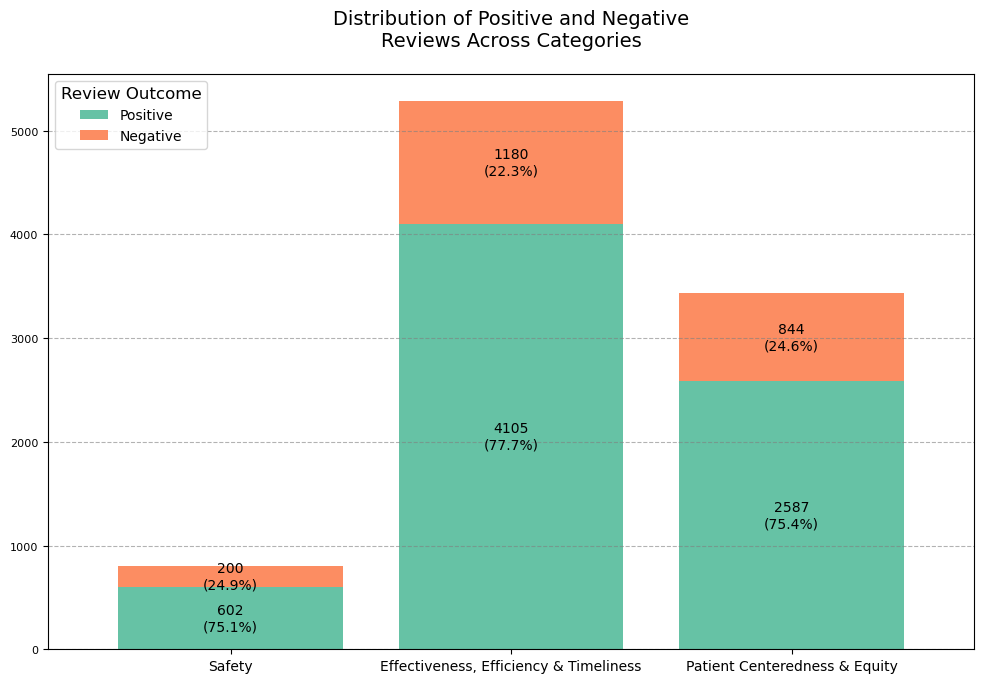

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

safety_reviews["is_positive"] = safety_reviews["is_positive"].replace({0: "Negative", 1: "Positive"})
effective_efficiency_timeliness_reviews["is_positive"] = effective_efficiency_timeliness_reviews["is_positive"].replace({0: "Negative", 1: "Positive"})
patient_centeredness_equity_reviews["is_positive"] = patient_centeredness_equity_reviews["is_positive"].replace({0: "Negative", 1: "Positive"})

safety_values = safety_reviews["is_positive"].value_counts()
efficiency_values = effective_efficiency_timeliness_reviews["is_positive"].value_counts()
patient_centeredness_equity_values = patient_centeredness_equity_reviews["is_positive"].value_counts()

safety_df = safety_values.rename_axis('Review').reset_index(name='Safety')
efficiency_df = efficiency_values.rename_axis('Review').reset_index(name='Effectiveness, Efficiency & Timeliness')
patient_centeredness_equity_df = patient_centeredness_equity_values.rename_axis('Review').reset_index(name='Patient Centeredness & Equity')

df = pd.merge(safety_df, efficiency_df, on='Review')
df = pd.merge(df, patient_centeredness_equity_df, on='Review')

df.set_index('Review', inplace=True)
df = df.T

sns.set_palette("Set2")

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(10, 7))

bars = df.plot(kind='bar', stacked=True, ax=ax, width=0.8)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

iter = 0

for bar in bars.patches:
    height = bar.get_height()
    current_category = df.iloc[iter]
    total = current_category.sum()

    percentage = f'{100 * height/total:.1f}%'
    
    text_x = bar.get_x() + bar.get_width() / 2
    if height < total * 0.05:
        text_y = bar.get_y() + height + total * 0.05
    elif height > total * 0.95: 
        text_y = bar.get_y() + height - total * 0.05
    else:
        text_y = bar.get_y() + height / 2
    
    ax.text(text_x, text_y, f'{int(height)}\n({percentage})', ha='center', va='center', color='black', fontsize=10)

    iter += 1

    if iter == 3:
        iter = 0
    

plt.title("Distribution of Positive and Negative\nReviews Across Categories", fontsize=14, pad=20)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=8)
plt.legend(title='Review Outcome', title_fontsize='12', fontsize='10', loc='upper left')

plt.tight_layout()
plt.show()

# Plot Distribution of Positive Percentage in all Puskesmas

In [256]:
import pandas as pd

detail_puskesmas = pd.read_csv("puskesmas_detail.csv")

In [257]:
import plotly.express as px

detail_puskesmas = detail_puskesmas.sort_values("positive_percentage", ascending=True)
detail_puskesmas = detail_puskesmas[detail_puskesmas["puskesmas_name"] != "Puskesmas Dr. Soetomo"]

total_rows = len(detail_puskesmas)
intervals = 10
step = max(total_rows // intervals, 1)

indices = [0]
indices.extend(range(step, total_rows - step, step))
if total_rows > 1:
    indices.append(total_rows - 1)

unique_indices = sorted(set(indices))

filtered_puskesmas = detail_puskesmas.iloc[unique_indices]

fig = px.bar(
    filtered_puskesmas,
    x="positive_percentage",
    y="puskesmas_name",
    labels={"positive_percentage": "", "puskesmas_name": "Puskesmas Name"},
    text="positive_percentage",
    color="positive_percentage",
    orientation='h',
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    hover_data=["positive_percentage", "review_num"]
)

fig.update_traces(marker_line_color="darkgrey", marker_line_width=1, texttemplate='%{text:.2f}', textposition='outside')

fig.update_layout(
    yaxis_title=None,  # Hides the y-axis title
    xaxis_title="Positive Review (%)",
    title="Positive Review Percentage Distribution<br>for Puskesmas in Surabaya (Every 10 Steps)",
    height=600,
    width=800,
    font=dict(family="Helvetica, sans-serif", size=12, color="black"),
    plot_bgcolor='rgba(255,255,255,1)',
    title_font=dict(size=20, color="black", family="Helvetica, sans-serif"),
    xaxis_title_font=dict(size=14, color="black", family="Helvetica, sans-serif"),
    yaxis_title_font=dict(size=14, color="black", family="Helvetica, sans-serif"),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    margin=dict(t=100, b=100, l=100, r=100),
)
fig.show()

# Save Detailed Puskesmas Review Conclusion

In [258]:
detail_puskesmas.head()

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
0,Puskesmas Morokrembangan,dr. Nurul Ihsani,Jln. Tambakasri 13/7 Morokrembangan,(031) 7493259,https://www.google.com/maps/place/Puskesmas+Mo...,"1,9",(108),-7.234781,112.712443,"Puskesmas Moro Krembangab, Jalan Tambak Asri X...",10.666667
1,Puskesmas Sidotopo,dr. Galih Satryo Utomo,"Jl. Pegirian No.239, Sidotopo",(031) 3767735,https://www.google.com/maps/place/Puskesmas+Si...,"2,8",(80),-7.230348,112.745882,"Puskesmas Sidotopo, Jalan Sidodadi, RW 07, Sim...",27.659574
2,Puskesmas Mojo,"dr. Ratna Megasari, M.Kes",Jln. Mojo Klanggru Wetan 2/11,(031) 5932332,https://www.google.com/maps/place/Puskesmas+Mo...,"2,6",(285),-7.270902,112.770824,"Puskesmas Mojo Surabaya, Jalan Mojo Klanggru W...",31.606218
3,Puskesmas Kenjeran,dr. Rosna Suswanti,Jl. Tambak Deres 2 Surabaya,089515356046,https://www.google.com/maps/place/Puskesmas+Ke...,"3,2",(165),-7.241111,112.795279,"Puskesmas Kenjeran, Jalan Abdul Latif, RW 01, ...",38.461538
4,Puskesmas Kalirungkut,dr. Bernadetta Martini,Jln. Rungkut Puskesmas No. 1,(031) 8700668,https://www.google.com/maps/place/Puskesmas+Ka...,"3,4",(289),-7.322218,112.770762,"Puskesmas Kalirungkut, Jalan Puskesmas, RW 07,...",40.000000


In [259]:
detail_puskesmas.to_csv("puskesmas_detail.csv", index=False)